Performance Cost Estimation of Distributed Streaming Workflows with Bayesian Optimization
==================================

This notebook is a demonstration of Bayesian Optimization method for estimating the performance of distributed streaming workflows with Gaussian Processes. More specifically, we use Bayesian Optimization to estimate the throughput of a single Apache Spark or Apache Flink streaming workflow by providing as a feature vector the set of execution parameters.  The estimation procedure has the following structure:

1) We parse the CSV file which contains the feature vector along with the true estimation value of the throughput from different executions of the workflow. Each line of the CSV file contains information about a single workflow execution.

2) Then, we set the feature space for Bayesian Optimization.

3) Afterwards, we choose the first “x” samples from the CSV file in order to construct the initial model for Bayesian Optimization. The selection of the first “x” samples can be performed by following a random policy or from a low discrepancy Sobol sequence.

4) Following the selection of “x” initial samples, we then set the Gaussian Process Regressor, the type of Kernel and the Acquisition Function Policy. The acquisition function can be one of “Expected Improvement - EI” or “Probability of Improvement - PI” or “Lower Confidence Bound -LCB”. Then we fit the “x” samples to Bayesian Optimization.

5) For the remaining “k” samples of the CSV file (i.e. k=N-x) we let Bayesian Optimization to choose the next evaluation point according to acquisition function. The process of asking Bayesian Optimization for the next point of evaluation as well as the process of updating the current model is performed in an asynchronous fashion. This is helpful for real time applications where the next point of evaluation might be unavailable from historical executions and therefore it has to be retrieved from a real time execution of the workflow. This stage is an iterative process and the user can stop the evaluation when she/he wishes. 

6) When the evaluation of Bayesian Optimization is completed we print execution metrics, such as number of model evaluations, number of chosen CSV samples, etc. Furthermore we plot two figures: 

    Figure 1: L1-Distance & R2-Score vs. Percentage of Explored Space
    Figure 2: Convergence Plot (i.e. max value) vs. Percentage of Explored Space
    
7) Finally, we provide a script that prints for every sample the true throughput and the estimation along with the sigma value and 0.95 confidence interval.

 
 
We considered using Bayesian Optimization for the purpose of performance cost estimation for the following reasons:

A) Bayesian Optimization is very well suited for optimization problems, under constraints, of costly black-box functions. This plays an important factor to our case as we do not have prior knowledge over the distribution of the function. Furthermore, running unnecessary benchmarks of distributed streaming workflows is in fact a very costly operation regarding time and cluster resources.

B) Bayesian Optimization follows a sequential design strategy and therefore it doesn’t require an initial sample to construct the underlying model.

C) Bayesian Optimization treats every point of the search space as a random variable and therefore it provides value estimation with confidence interval for every point (i.e. in our case a point is the feature vector which contains the set of execution parameters of the workflow). Moreover, the acquisition function offers the user to influence the construction of the model according to the use case (e.g. “exploration” vs. “exploitation”).

This notebook is based on the “scikit-optimize” Python library (https://scikit-optimize.github.io/stable/).

Dataset Folder
--

In this notebook we are using the "Flink Join Workflow" dataset which contains execution metrics from different executions of a 5 second Flink tumbling window join operator. These metrics were collected by using the Benchmark Platform.

Each line of the CSV files contains the set of execution parameters of a single experiment along with the achieved throughput of the operator. 

For example: "Flink_Join,CustomSource,CustomSource,100000,100000,CustomSource,1,83606,5100000,61019"


Fields per CSV line
--
csv column 1 = Workflow name

Bayesian optimization features:

    feature 1(csv column 2): Stream 1 source type, source1 = "KafkaTopic", "CustomSource"

    feature 2(csv column 3): Stream 2 source type, source2 = "KafkaTopic", "CustomSource"

    feature 3(csv column 4): Stream 1 rate(t/s), source1Rate = 1000, 10000, 100000, 1000000

    feature 4(csv column 5): Stream 2 rate(t/s), source2Rate = 1000, 10000, 100000, 1000000

    feature 5(csv column 6): Stream output type, outputSource = "CustomSource"

    feature 6(csv column 7): Flink task slots, parallelism = 1, 4, 8, 12

    Output feature(csv column 8): Throughput(t/s), This is the value that we wish to predict.

csv column 9 = Number of processed tuples

csv column 10 = Workflow duration time in milliseconds

Execution Instructions
--
The user must execute the following scripts from start to bottom. 

# 1) Parse dataset

In [1]:
%matplotlib inline
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np
import glob
import csv
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

########################### 
objective_maximize=True
###########################

PATH = "Flink Join Workflow\\"
output_col=7
data = []

for files in glob.glob(PATH+"*.csv"):
#     print(files)
    with open(files, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
        for row in reader:
            if len(row)!= 0:
                data.append(row[1:len(row)])
#                 print(row)

if objective_maximize == True:
    for row in data:
        row[output_col-1]= str(-float(row[output_col-1]))
        
print("data dimensions=",np.shape(data))

# print("\n\ndata=",data)
#for row in data:
#    print("features=",row[0:6],",throughput=",row[output_col-1])

Automatically created module for IPython interactive environment
data dimensions= (256, 9)


**Note.** A simple script to visualize throughput vs. parallelism for fixed [source1, source2, source1Rate, source2Rate, outputSource]

Parallelism= [1, 4, 8, 12]
Throughput= [59783.0, 122472.0, 155560.0, 207725.0]


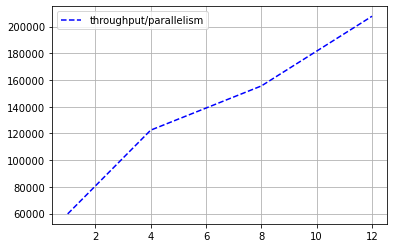

In [2]:
data2=[]
for row in data:
    if row[0] =="CustomSource" and row[1] =="CustomSource" and int(row[2]) == 1000000 \
    and int(row[3]) == 1000000 and row[4] =="CustomSource":
        if objective_maximize == True:
            data2.append([int(row[5]),-float(row[output_col-1])])
        else:   
            data2.append([int(row[5]),float(row[output_col-1])])

data2.sort(key=lambda x:int(x[0]))
parallelism=[exp[0] for exp in data2]
throughput=[exp[1] for exp in data2]
print("Parallelism=",parallelism)
print("Throughput=",throughput)

plt.plot(parallelism, throughput, "b--", label="throughput/parallelism")
plt.legend()
plt.grid()
plt.show()

# 2) Set space for Bayesian Optimization

In [3]:
from skopt.space import Integer, Categorical

# Remember the feature vector:
# feature 1(csv column 2): Stream 1 source type, source1 = "KafkaTopic", "CustomSource"
# feature 2(csv column 3): Stream 2 source type, source2 = "KafkaTopic", "CustomSource"
# feature 3(csv column 4): Stream 1 rate(t/s), source1Rate = 1000, 10000, 100000, 1000000
# feature 4(csv column 5): Stream 2 rate(t/s), source2Rate = 1000, 10000, 100000, 1000000
# feature 5(csv column 6): Stream output type, outputSource = "KafkaTopic", "CustomSource"
# feature 6(csv column 7): Job Parallelism = 1, 4, 8, 12

def set_space():
    
    SPACE_CAT = [
        Categorical(['KafkaTopic', 'CustomSource'], name='source1'),
        Categorical(['KafkaTopic', 'CustomSource'], name='source2'),
        Categorical(['1000', '10000', '100000','1000000',], name='source1Rate'),
        Categorical(['1000', '10000', '100000','1000000',], name='source2Rate'),
#         Categorical(['KafkaTopic', 'CustomSource'], name='outputSource'),
        Categorical(['CustomSource'], name='outputSource'),
        Categorical(['1', '4', '8', '12'], name='parallelism')
    ]
    
    return SPACE_CAT

# 3) Select initial sample "x"

The selection of the sample can be performed by following a random policy or from a low discrepancy Sobol sequence.

In [4]:
from skopt.traverser.utils import use_named_args
import sobol_seq as sb

# convert list data to python dictionary with composite key=tuple(features)
def initialize_data_map():
    data_map = {}
    for row in data:
        data_map[tuple(row[0:6])]=float(row[output_col-1])    
    # print(data_map)
    return data_map

def choose_x_random_experiments(x,data_map,opt_seed,seed):
    if opt_seed==True:
        random.seed(seed)
    else:
        random.seed(None)
        
    exp_index=random.sample(range(0, len(data_map)), x)
    print("total experiments = ",len(data_map))
    print("number of chosen experiments = ",len(exp_index))

    exp_features=[]
    for index in exp_index:
        exp_features.append(list(list(data_map)[index]))
    
    exp_values=[]
    for key in exp_features:
        exp_values.append(data_map.pop(tuple(key)))
        
    print("exp_features = ",exp_features,"\n")
    print("exp_values = ",exp_values,"\n")
    print("remaining experiments= ",len(data_map),"\n")
    
    return [exp_features,exp_values]


def generate_sobol_sequence(x,data_map):
    exp_features=[]
    sob_seq_array=sb.i4_sobol_generate(5, x)
    print("sob_seq_array=",sob_seq_array,"\n")
    
    for sob_seq in sob_seq_array:
        
        feature=[]
        if sob_seq[0] <=0.5:
            source1_type='KafkaTopic'
        else:
            source1_type='CustomSource'
        feature.append(source1_type)
        
        if sob_seq[1] <=0.5:
            source2_type='KafkaTopic'
        else:
            source2_type='CustomSource'
        feature.append(source2_type)
        
        if sob_seq[2] <=0.25:
            source1_rate='1000'
        elif sob_seq[2] <=0.5:
            source1_rate='10000'
        elif sob_seq[2] <=0.75:
            source1_rate='100000'
        else:
            source1_rate='1000000'
        feature.append(source1_rate)
        
        if sob_seq[3] <=0.25:
            source2_rate='1000'
        elif sob_seq[3] <=0.5:
            source2_rate='10000'
        elif sob_seq[3] <=0.75:
            source2_rate='100000'
        else:
            source2_rate='1000000'
        feature.append(source2_rate)
        
        output_type='CustomSource'
        feature.append(output_type)
        
        if sob_seq[4] <=0.25:
            parallelism='1'
        elif sob_seq[4] <=0.5:
            parallelism='4'
        elif sob_seq[4] <=0.75:
            parallelism='8'
        else:
            parallelism='12'
            
        feature.append(parallelism)
        exp_features.append(feature)         
   
       
    exp_values=[]
    for key in exp_features:
        exp_values.append(data_map.pop(tuple(key)))
        
    print("exp_features=",exp_features,"\n")
    print("exp_values=",exp_values,"\n")

    return [exp_features,exp_values]
        
#data_map=initialize_data_map()
#generate_sobol_sequence(10,data_map,False)

# 4) Initialize Bayesian Optimizer and feed initial sample "x"

In [5]:
from skopt import Optimizer
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import HammingKernel
from skopt.learning.gaussian_process.kernels import Matern

#rand_state contains the seed for random selection of the initial sample "x"
rand_state=10

#initial_exp is the size of the initial sample "x"
initial_exp=1

data_map=initialize_data_map()

#uncomment the following and comment "generate_sobol_sequence()" for random selection of the intial sample "x"
#exp_features,exp_values=choose_x_random_experiments(initial_exp,data_map,True,rand_state)

#choose the initial sample "x" from a Sobol Sequence
exp_features,exp_values=generate_sobol_sequence(initial_exp,data_map)

gpr= GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                     kernel=1**2 * HammingKernel(length_scale=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
                     n_restarts_optimizer=2, noise=1e-08, normalize_y=True,
                     optimizer='fmin_l_bfgs_b', random_state=rand_state)

#initialize Async optimizer
acq_func="LCB"               #"EI","PI", "LCB" 
acq_func_ei_xi=100           #default=0.01
acq_func_lcb_kappa=100000    #default=1.96
thisdict = {'xi': acq_func_ei_xi,'kappa': acq_func_lcb_kappa}

model = Optimizer(
    dimensions=set_space(),
    acq_func=acq_func,
    base_estimator=gpr,
    n_initial_points=initial_exp,
    n_random_starts=0,
    random_state=rand_state,
    acq_optimizer='auto',
    acq_func_kwargs=thisdict
)

#feed initial sample "x" to Bayesian Optimization
model_res=model.tell(exp_features, exp_values,fit=True)

sob_seq_array= [[0.5 0.5 0.5 0.5 0.5]] 

exp_features= [['KafkaTopic', 'KafkaTopic', '10000', '10000', 'CustomSource', '4']] 

exp_values= [-18947.0] 



For further inspection of the results, attributes of the `res` named tuple
provide the following information:

- `x` [float]: location of the minimum/maximum.
- `fun` [float]: function value at the minimum/maximum.
- `models`: surrogate models used for each iteration.
- `x_iters` [array]:
   location of function evaluation for each iteration.
- `func_vals` [array]: function value for each iteration.
- `space` [Space]: the optimization space.
- `specs` [dict]: parameters passed to the function.



In [6]:
print(model_res)

          fun: -18947.0
    func_vals: array([-18947.])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * HammingKernel(0, 0, 0, 0, 0, 0) + WhiteKernel(noise_level=1e-08),
                         n_restarts_optimizer=2, noise=1e-08, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=10)]
 random_state: RandomState(MT19937) at 0x1E35F894740
        space: Space([Categorical(categories=('KafkaTopic', 'CustomSource'), prior=None),
       Categorical(categories=('KafkaTopic', 'CustomSource'), prior=None),
       Categorical(categories=('1000', '10000', '100000', '1000000'), prior=None),
       Categorical(categories=('1000', '10000', '100000', '1000000'), prior=None),
       Categorical(categories=('CustomSource',), prior=None),
       Categorical(categories=('1', '4', '8', '12'), prior=None)])
        specs: None
            x: ['KafkaTopic', 'KafkaTopic', '10000', '10000', 'CustomSource', '4']


# 5) For the remaining k=N-x samples ask Bayesian Optimization for the next point of evaluation

This function represents a single iteration of Bayesian Optimization. During the iteration we calculate L1 distance, R2 score and we return the updated model. 

In [7]:
def update_model(model,init_data_map,data_map,initial_fit,model_res_init):
    exp_discovered=False
    
    # update model
    if initial_fit == False:
        model_features = model.ask()
        features_key=tuple(model_features)
        throughput=init_data_map.get(tuple(features_key))
        model_res=model.tell(model_features, throughput,fit=True)

        if features_key in data_map:
            data_map.pop(features_key)
            exp_discovered=True
    if initial_fit == True:
        exp_discovered=True
        model_res=model_res_init
        
    if exp_discovered == True:    
        # calculate metrics
        l1_sum=0
        y_true_list=[]
        y_pred_list=[]

        gp = model.models[-1]

        for index in range(len(init_data_map)):
            feature=list(list(init_data_map)[index])
            feature_gp=model.space.transform([feature])
            y_pred, sigma = gp.predict(feature_gp, return_std=True)
            y_true=list(init_data_map.values())[index]
            # calculate l1 distance
            l1=np.abs(y_pred[0]-y_true)
            l1_sum+=l1
            # calculate R2 score
            y_true_list.append(y_true)
            y_pred_list.append(y_pred[0])

        y_true_list=np.array(y_true_list).reshape(-1, 1)
        y_pred_list=np.array(y_pred_list).reshape(-1, 1)
        u=((y_true_list - y_pred_list) ** 2).sum()
        v=((y_true_list - y_pred_list.mean()) ** 2).sum()
        r2_score=(1 - u/v)
        
        return [l1_sum,model_res,r2_score]
    else:
        return [None,model_res,None]

##### The following script initializes the data structures used for Bayesian Optimization iterations.

In [8]:
exp_iter=[]
exp_iter_l1=[]
exp_iter_r2=[]
model_res_fun=[]
initial_fit=True
total_calls=0

init_data_map=initialize_data_map()
initial_exp=len(init_data_map)-len(data_map)
number_of_discovered_exp=initial_exp

l1_sum,model_res,r2_score=update_model(model,init_data_map,data_map,initial_fit,model_res)
exp_iter.append(initial_exp)
exp_iter_l1.append(l1_sum)
exp_iter_r2.append(r2_score)
if objective_maximize == True:
    model_res_fun.append(-model_res.fun)
else:
    model_res_fun.append(model_res.fun)

print("Number of chosen experiments before B.O call=",initial_exp,"\n")
print("Number of unchosen experiments before B.O call=",len(data_map),"\n")
print("Total iterations of Bayesian Optimization before B.O call=",total_calls,"\n")

#print("exp_iter=",exp_iter,"\n")
#print("exp_iter_l1=",exp_iter_l1,"\n")
#print("exp_iter_r2=",exp_iter_r2,"\n")
#print("model_res_fun=",model_res_fun,"\n")

Number of chosen experiments before B.O call= 1 

Number of unchosen experiments before B.O call= 255 

Total iterations of Bayesian Optimization before B.O call= 0 



##### The following script calls Bayesian Optimization for a fixed number of iterations.

In [9]:
###########################
iterations=150
###########################

initial_fit=False
for index in range(iterations):
    total_calls+=1
    print("loop=",index)
    l1_sum,model_res,r2_score=update_model(model,init_data_map,data_map,initial_fit,model_res)
    if l1_sum!=None and r2_score!=None:
        number_of_discovered_exp+=1
        print("number_of_discovered_exp=",number_of_discovered_exp,"\n")
        exp_iter.append(number_of_discovered_exp)
        exp_iter_l1.append(l1_sum)
        exp_iter_r2.append(r2_score)
        if objective_maximize == True:
            model_res_fun.append(-model_res.fun)
        else:
            model_res_fun.append(model_res.fun)

print("Size of space=",len(init_data_map),"\n")
print("Number of chosen experiments=",len(init_data_map)-len(data_map),"\n")
print("Number of unchosen experiments=",len(data_map),"\n")
print("Total iterations of Bayesian Optimization=",total_calls,"\n")

loop= 0
number_of_discovered_exp= 2 

loop= 1
number_of_discovered_exp= 3 

loop= 2
number_of_discovered_exp= 4 

loop= 3
number_of_discovered_exp= 5 

loop= 4
number_of_discovered_exp= 6 

loop= 5
number_of_discovered_exp= 7 

loop= 6
number_of_discovered_exp= 8 

loop= 7
number_of_discovered_exp= 9 

loop= 8
number_of_discovered_exp= 10 

loop= 9
number_of_discovered_exp= 11 

loop= 10
number_of_discovered_exp= 12 

loop= 11
number_of_discovered_exp= 13 

loop= 12
number_of_discovered_exp= 14 

loop= 13
number_of_discovered_exp= 15 

loop= 14
number_of_discovered_exp= 16 

loop= 15
number_of_discovered_exp= 17 

loop= 16
number_of_discovered_exp= 18 

loop= 17
number_of_discovered_exp= 19 

loop= 18
number_of_discovered_exp= 20 

loop= 19
number_of_discovered_exp= 21 

loop= 20
number_of_discovered_exp= 22 

loop= 21
number_of_discovered_exp= 23 

loop= 22
number_of_discovered_exp= 24 

loop= 23
number_of_discovered_exp= 25 

loop= 24
number_of_discovered_exp= 26 

loop= 25
number_of

# 6) Print execution metrics and figures

No handles with labels found to put in legend.


Size of space= 256 

Number of chosen experiments= 151 

Number of unchosen experiments= 105 

Total iterations of Bayesian Optimization= 150 

Best maximum found =  801517.0  at location x= ['CustomSource', 'CustomSource', '1000', '1000000', 'CustomSource', '12'] 

Percentage of explored space= 58.984375 %



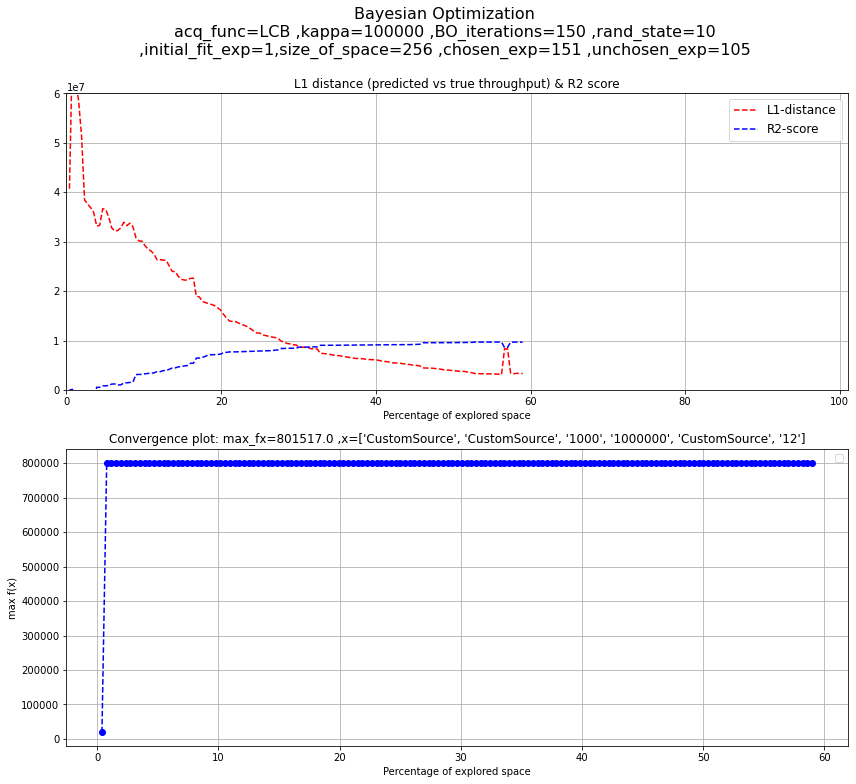

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
from skopt.plots import plot_convergence

print("Size of space=",len(init_data_map),"\n")
print("Number of chosen experiments=",len(init_data_map)-len(data_map),"\n")
print("Number of unchosen experiments=",len(data_map),"\n")
print("Total iterations of Bayesian Optimization=",total_calls,"\n")

#useful prints
#print("exp_iter=",exp_iter,"len=",len(exp_iter),"\n")
#print("exp_iter_l1=",exp_iter_l1,"len=",len(exp_iter_l1),"\n")
#print("exp_iter_r2=",exp_iter_r2,"len=",len(exp_iter_r2),"\n")
#print("model_res_fun=",model_res_fun,"len=",len(model_res_fun),"\n")

#print("len exp_iter=",len(exp_iter),"\n")
#print("len exp_iter_l1=",len(exp_iter_l1),"\n")
#print("len exp_iter_r2=",len(exp_iter_r2),"\n")
#print("len model_res_fun=",len(model_res_fun),"\n")

if objective_maximize == True:
    print("Best maximum found = ",-model_res.fun," at location x=",model_res.x,"\n")
else:
    print("Best minimum found = ",model_res.fun," at location x=",model_res.x,"\n")
    
exp_iter_percentage=[exp_iter_i*100/len(data) for exp_iter_i in exp_iter]

#print("exp_iter_percentage=",exp_iter_percentage,"len=",len(exp_iter_percentage),"\n")
#print("exp_iter_percentage=",len(exp_iter_percentage),"\n")
print("Percentage of explored space=",exp_iter_percentage[len(exp_iter_percentage)-1],"%\n")

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(14)

if acq_func == "EI":
    acq_func_param_type=" ,xi="
    acq_func_param_value=acq_func_ei_xi
elif acq_func == "LCB":
    acq_func_param_type=" ,kappa="
    acq_func_param_value=acq_func_lcb_kappa
elif acq_func == "PI":
    acq_func_param_type=" ,xi="
    acq_func_param_value=acq_func_ei_xi
    
top_title="Bayesian Optimization\nacq_func="+acq_func+ \
    acq_func_param_type+str(acq_func_param_value)+ \
    " ,BO_iterations="+str(total_calls)+ \
    " ,rand_state="+str(rand_state)+ \
    "\n,initial_fit_exp="+str(initial_exp)+ \
    ",size_of_space="+str(len(init_data_map))+ \
    " ,chosen_exp="+str((len(init_data_map)-len(data_map)))+ \
    " ,unchosen_exp="+str(len(data_map))
fig.suptitle(top_title, fontsize=16)
    
plt.subplot(2, 1, 1)
plt.plot(exp_iter_percentage, exp_iter_l1, "r--",label="L1-distance")
scale_r2_score= [r*10000000 for r in exp_iter_r2]
plt.plot(exp_iter_percentage, scale_r2_score, "b--",label="R2-score")
plt.ylim(0.0, 60000000)
plt.xlim(0, 101)
plt.legend(loc="upper right", prop={'size': 12})
plt.grid()
plt.title("L1 distance (predicted vs true throughput) & R2 score")
plt.xlabel("Percentage of explored space")

plt.subplot(2, 1, 2)
plt.plot(exp_iter_percentage, model_res_fun, linestyle='--', marker='o', color='b')
#plt.ylim(0, 1000000)
#plt.xlim(0, 101)
plt.grid()
if objective_maximize == True:
    plt.ylabel("max f(x)")
    title2="Convergence plot: max_fx="+str(-model_res.fun)+" ,x="+str(model_res.x)
else:
    plt.ylabel("min f(x)")
    title2="Convergence plot: min_fx="+str(model_res.fun)+" ,x="+str(model_res.x)
    
plt.title(title2)    
plt.xlabel("Percentage of explored space")
    
plt.legend()
plt.show()

fig_title="acq_func="+acq_func+ \
    acq_func_param_type+str(acq_func_param_value)+ \
    ",BO_iters="+str(total_calls)+ \
    ",rand_state="+str(rand_state)+ \
    ",initial_fit_sb_exp="+str(initial_exp)
fig_path="figures\\"
fig_total_path=fig_path+fig_title
fig.savefig(fig_total_path+'.pdf', format='pdf', dpi=1000)
fig.savefig(fig_total_path+'.eps', format='eps', dpi=1000)

##### The following script prints performance metrics about a fixed model returned by Bayesian Optimization.

In [11]:
check_index=20
print("L1 distance=",exp_iter_l1[check_index],"after",exp_iter[check_index]-1,"B.O calls\n")
print("R2 score=",exp_iter_r2[check_index],"after",exp_iter[check_index]-1,"B.O calls\n")
print("Optimum throughput=",model_res_fun[check_index],"after",exp_iter[check_index]-1,"B.O calls\n")
print("Percentage of explored space=",exp_iter_percentage[check_index],"% after",exp_iter[check_index]-1,"B.O calls\n")

L1 distance= 33762248.72110757 after 20 B.O calls

R2 score= 0.1529568975225546 after 20 B.O calls

Optimum throughput= 801517.0 after 20 B.O calls

Percentage of explored space= 8.203125 % after 20 B.O calls



# 7) Print for every point of the space the true throughput vs. estimation

In [12]:
# print(model_res)
print("Performance Cost Estimation after",len(model.models)-1,"B.O calls\n")

init_data_map=initialize_data_map()
gp = model.models[len(model.models)-1]

for index in range(len(init_data_map)):
    feature=list(list(init_data_map)[index])
    feature_gp=model.space.transform([feature])
    y_pred, sigma = gp.predict(feature_gp, return_std=True)
    y_true=list(init_data_map.values())[index]
    print("\nTrue Experiment: throughput=",-y_true,", with features=",feature)
    CI_95=[(y_pred-1.9600*sigma)[0], (y_pred+1.9600*sigma)[0]]
    print("GP Predicted: throughput=",-y_pred[0],",sigma=",sigma)
    print("GP Predicted: 0.95 confidence interval=",[-float(i) for i in CI_95])

print(model_res)

Performance Cost Estimation after 150 B.O calls


True Experiment: throughput= 83606.0 , with features= ['CustomSource', 'CustomSource', '100000', '100000', 'CustomSource', '1']
GP Predicted: throughput= 109963.77978369538 ,sigma= [227.75127692]
GP Predicted: 0.95 confidence interval= [110410.17228645123, 109517.38728093954]

True Experiment: throughput= 221967.0 , with features= ['CustomSource', 'CustomSource', '10000', '1000000', 'CustomSource', '1']
GP Predicted: throughput= 221966.9999999969 ,sigma= [0.00010057]
GP Predicted: 0.95 confidence interval= [221967.00019710683, 221966.99980288694]

True Experiment: throughput= 1807.0 , with features= ['CustomSource', 'KafkaTopic', '1000', '1000', 'CustomSource', '1']
GP Predicted: throughput= 1807.0000000054424 ,sigma= [0.00010057]
GP Predicted: 0.95 confidence interval= [1807.0001971153943, 1806.9998028954906]

True Experiment: throughput= 279622.0 , with features= ['CustomSource', 'CustomSource', '1000000', '1000', 'CustomSource', '1']


True Experiment: throughput= 278491.0 , with features= ['KafkaTopic', 'CustomSource', '1000', '1000000', 'CustomSource', '1']
GP Predicted: throughput= 278490.99999999185 ,sigma= [0.00010049]
GP Predicted: 0.95 confidence interval= [278491.00019695994, 278490.99980302376]

True Experiment: throughput= 10789.0 , with features= ['KafkaTopic', 'CustomSource', '1000', '10000', 'CustomSource', '1']
GP Predicted: throughput= 10789.000000013853 ,sigma= [0.00010035]
GP Predicted: 0.95 confidence interval= [10789.000196697927, 10788.99980332978]

True Experiment: throughput= 85192.0 , with features= ['KafkaTopic', 'CustomSource', '1000', '100000', 'CustomSource', '1']
GP Predicted: throughput= 101059.83882773879 ,sigma= [227.75127692]
GP Predicted: 0.95 confidence interval= [101506.23133049463, 100613.44632498294]

True Experiment: throughput= 10649.0 , with features= ['KafkaTopic', 'CustomSource', '10000', '1000', 'CustomSource', '1']
GP Predicted: throughput= 10649.000000013912 ,sigma= [0.00


True Experiment: throughput= 95357.0 , with features= ['KafkaTopic', 'KafkaTopic', '100000', '10000', 'CustomSource', '4']
GP Predicted: throughput= 95357.00000000774 ,sigma= [0.00010049]
GP Predicted: 0.95 confidence interval= [95357.00019697583, 95356.99980303965]

True Experiment: throughput= 86678.0 , with features= ['KafkaTopic', 'KafkaTopic', '100000', '1000', 'CustomSource', '4']
GP Predicted: throughput= 105407.81091040658 ,sigma= [216.06726177]
GP Predicted: 0.95 confidence interval= [105831.30274348296, 104984.3190773302]

True Experiment: throughput= 297660.0 , with features= ['KafkaTopic', 'KafkaTopic', '1000000', '10000', 'CustomSource', '4']
GP Predicted: throughput= 297660.0000000016 ,sigma= [0.00010035]
GP Predicted: 0.95 confidence interval= [297660.00019668567, 297659.9998033175]

True Experiment: throughput= 167077.0 , with features= ['KafkaTopic', 'KafkaTopic', '1000000', '100000', 'CustomSource', '4']
GP Predicted: throughput= 167077.00000000396 ,sigma= [0.0001003

      x_iters: [['KafkaTopic', 'KafkaTopic', '10000', '10000', 'CustomSource', '4'], ['CustomSource', 'CustomSource', '1000', '1000000', 'CustomSource', '12'], ['CustomSource', 'KafkaTopic', '1000000', '1000000', 'CustomSource', '12'], ['KafkaTopic', 'CustomSource', '10000', '100000', 'CustomSource', '4'], ['CustomSource', 'KafkaTopic', '100000', '100000', 'CustomSource', '1'], ['KafkaTopic', 'KafkaTopic', '1000', '100000', 'CustomSource', '1'], ['KafkaTopic', 'CustomSource', '1000000', '1000000', 'CustomSource', '12'], ['KafkaTopic', 'CustomSource', '100000', '1000000', 'CustomSource', '4'], ['CustomSource', 'CustomSource', '100000', '1000', 'CustomSource', '8'], ['KafkaTopic', 'CustomSource', '1000', '10000', 'CustomSource', '8'], ['KafkaTopic', 'KafkaTopic', '1000', '1000000', 'CustomSource', '1'], ['CustomSource', 'KafkaTopic', '1000000', '1000', 'CustomSource', '8'], ['KafkaTopic', 'KafkaTopic', '10000', '1000000', 'CustomSource', '1'], ['CustomSource', 'CustomSource', '10000', '1